In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from sklearn import metrics


In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
data = pd.read_csv("/Users/jainivedhitha/Downloads/train.csv")

In [4]:
data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [6]:
data.isnull().sum()*100

Id                            0
OrgId                         0
IncidentId                    0
AlertId                       0
Timestamp                     0
DetectorId                    0
AlertTitle                    0
Category                      0
MitreTechniques       546838600
IncidentGrade           5134000
ActionGrouped         946077300
ActionGranular        946077300
EntityType                    0
EvidenceRole                  0
DeviceId                      0
Sha256                        0
IpAddress                     0
Url                           0
AccountSid                    0
AccountUpn                    0
AccountObjectId               0
AccountName                   0
DeviceName                    0
NetworkMessageId              0
EmailClusterId        942002500
RegistryKey                   0
RegistryValueName             0
RegistryValueData             0
ApplicationId                 0
ApplicationName               0
OAuthApplicationId            0
ThreatFa

In [7]:
data.shape

(9516837, 45)

In [8]:
#REMOVING COLUMNS WHICH HAS 50% MORE MISSING DATA

threshold = len(data)*0.4
data = data.dropna(thresh=threshold,axis=1)

In [9]:
data.shape

(9516837, 36)

DUPLICATE DATA

In [10]:
data.duplicated().sum()

546298

In [11]:
data = data.drop_duplicates()

HANDLING MISSING DATA

In [12]:
data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5444222
IncidentGrade           47734
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
FileName                    0
FolderPath                  0
ResourceIdName              0
OSFamily                    0
OSVersion                   0
CountryCod

In [13]:
data["IncidentGrade"].fillna(data["IncidentGrade"].mode()[0],inplace=True)

In [14]:
data["Timestamp"]

0          2024-06-04T06:05:15.000Z
1          2024-06-14T03:01:25.000Z
2          2024-06-13T04:52:55.000Z
3          2024-06-10T16:39:36.000Z
4          2024-06-15T01:08:07.000Z
                     ...           
9516832    2024-06-08T15:26:08.000Z
9516833    2024-06-06T09:40:08.000Z
9516834    2024-06-11T22:51:03.000Z
9516835    2024-05-20T23:01:01.000Z
9516836    2024-06-03T23:51:52.000Z
Name: Timestamp, Length: 8970539, dtype: object

In [15]:
data["Timestamp"] = data["Timestamp"].str.replace(r"\.\d{3}Z$","Z",regex=True)

In [16]:

data["Timestamp"]

0          2024-06-04T06:05:15Z
1          2024-06-14T03:01:25Z
2          2024-06-13T04:52:55Z
3          2024-06-10T16:39:36Z
4          2024-06-15T01:08:07Z
                   ...         
9516832    2024-06-08T15:26:08Z
9516833    2024-06-06T09:40:08Z
9516834    2024-06-11T22:51:03Z
9516835    2024-05-20T23:01:01Z
9516836    2024-06-03T23:51:52Z
Name: Timestamp, Length: 8970539, dtype: object

In [17]:
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

In [18]:
data["Day"] = data["Timestamp"].dt.day
data["Month"] = data["Timestamp"].dt.month
data["Year"] = data["Timestamp"].dt.year
data["Hour"] = data["Timestamp"].dt.hour
data["Time"] =data["Timestamp"].dt.time

In [19]:
data.drop("Timestamp",axis=1,inplace=True)

In [20]:
data.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,...,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Year,Hour,Time
0,180388628218,0,612,123247,7,6,InitialAccess,NaN,TruePositive,Ip,...,5,66,31,6,3,4,6,2024,6,06:05:15
1,455266534868,88,326,210035,58,43,Exfiltration,NaN,FalsePositive,User,...,5,66,242,1445,10630,14,6,2024,3,03:01:25
2,1056561957389,809,58352,712507,423,298,InitialAccess,T1189,FalsePositive,Url,...,5,66,242,1445,10630,13,6,2024,4,04:52:55
3,1279900258736,92,32992,774301,2,2,CommandAndControl,NaN,BenignPositive,Url,...,5,66,242,1445,10630,10,6,2024,16,16:39:36
4,214748368522,148,4359,188041,9,74,Execution,NaN,TruePositive,User,...,5,66,242,1445,10630,15,6,2024,1,01:08:07


In [21]:
pd.set_option("display.max_columns", None)
data.head(1)

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Year,Hour,Time
0,180388628218,0,612,123247,7,6,InitialAccess,NaN,TruePositive,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,31,6,3,4,6,2024,6,06:05:15


In [22]:
data["FolderPath"].value_counts()

FolderPath
117668    8097467
0          113753
1           70670
2           60959
3           39966
           ...   
77931           1
58574           1
72272           1
106968          1
114529          1
Name: count, Length: 87832, dtype: int64

In [23]:
data["OSFamily"].value_counts()

OSFamily
5    8777297
0     189006
1       2732
2       1496
3          7
4          1
Name: count, dtype: int64

In [24]:
data["OSVersion"].value_counts()

OSVersion
66    8777304
0      186399
2        1892
1        1628
3        1125
4         732
6         362
5         266
8         132
9         109
10         89
7          81
11         66
12         54
16         38
13         32
14         31
15         22
19         18
17         17
20         16
22         15
21         14
24         13
26          7
25          7
27          6
31          5
28          5
35          4
33          4
40          3
38          3
37          3
41          3
42          3
29          3
23          2
45          2
30          2
34          2
44          2
46          2
43          2
65          1
59          1
63          1
53          1
62          1
36          1
58          1
48          1
64          1
51          1
56          1
52          1
47          1
60          1
Name: count, dtype: int64

In [25]:
data["AlertTitle"].value_counts()

AlertTitle
0         1320736
2          597423
1          480010
4          412029
3          412025
           ...   
112232          1
110362          1
110346          1
111797          1
110883          1
Name: count, Length: 86149, dtype: int64

In [26]:
data["ResourceIdName"].value_counts()

ResourceIdName
3586    8962395
0           390
1           329
2           274
3           253
         ...   
3072          1
2156          1
1614          1
840           1
3316          1
Name: count, Length: 2309, dtype: int64

In [27]:
data["EntityType"].value_counts()

EntityType
Ip                       2174998
User                     1922577
MailMessage              1004821
Machine                   698031
File                      682079
CloudLogonRequest         632503
Url                       589305
Mailbox                   348499
Process                   345069
CloudApplication          216797
CloudLogonSession         210556
MailCluster               106784
RegistryValue              11209
AzureResource               8144
RegistryKey                 7277
GenericEntity               4294
OAuthApplication            2595
Malware                     2580
SecurityGroup               1507
BlobContainer                306
Blob                         263
MailboxConfiguration         226
Nic                           49
IoTDevice                     31
ActiveDirectoryDomain         11
GoogleCloudResource           10
AmazonResource                 6
Container                      2
KubernetesCluster              2
ContainerImage                 2

In [28]:
data["MitreTechniques"].value_counts()

MitreTechniques
T1078;T1078.004                                          1343398
T1566                                                     513253
T1566.002                                                 505956
T1133                                                     145579
T1110;T1110.003;T1110.001                                  86614
                                                          ...   
T1484.001                                                      1
T0814;T0816                                                    1
T1021;T1021.002;T1074.002;T1078;T1078.002;T1080;T1570          1
T1098;T1078;T0859                                              1
T1078;T1078.001                                                1
Name: count, Length: 1193, dtype: int64

In [29]:
missing_data = data.groupby(data["MitreTechniques"].isnull())['IncidentGrade'].value_counts()
print(missing_data)

MitreTechniques  IncidentGrade 
False            TruePositive      1487523
                 BenignPositive    1116348
                 FalsePositive      922446
True             BenignPositive    2759186
                 TruePositive      1652603
                 FalsePositive     1032433
Name: count, dtype: int64


In [30]:
technique_counts=data.groupby(["IncidentGrade", "MitreTechniques"]).size().reset_index(name="count")
technique_counts

,IncidentGrade,MitreTechniques,count
0,BenignPositive,T0807,380
1,BenignPositive,T0807;T1204,8
2,BenignPositive,T0814,3
3,BenignPositive,T0820;T0816,595
4,BenignPositive,T0820;T0853;T0807;T0866,12
...,...,...,...
1990,TruePositive,T1598;T1566,2
1991,TruePositive,T1603,1
1992,TruePositive,T1616;T1090,4
1993,TruePositive,T1621;T1078,9


In [31]:
sorted_techniques= technique_counts.sort_values(["IncidentGrade","count"],ascending=[True, False])
sorted_techniques


,IncidentGrade,MitreTechniques,count
960,BenignPositive,T1566,271684
963,BenignPositive,T1566.002,226598
961,BenignPositive,T1566.001,57007
934,BenignPositive,T1559;T1106;T1059.005,37869
605,BenignPositive,T1078;T1078.004,36600
...,...,...,...
1576,TruePositive,T0865;T1566;T1098;T1078,1
1791,TruePositive,T1070;T1562,1
1837,TruePositive,T1098;T1556,1
1989,TruePositive,T1595;T1464,1


In [32]:
most_common=sorted_techniques.loc[sorted_techniques.groupby("IncidentGrade")["count"].idxmax()]
most_common

,IncidentGrade,MitreTechniques,count
960,BenignPositive,T1566,271684
1318,FalsePositive,T1078;T1078.004,308314
1810,TruePositive,T1078;T1078.004,998484


In [33]:
fill_mapping = {
    "BenignPositive":"T1566.002",
    "FalsePositive":"T1078;T1078.004",
    "TruePositive":"T1078;T1078.004"
}

In [34]:
for grade,technique in fill_mapping.items():
    data.loc[data["IncidentGrade"] == grade,"MitreTechniques"] = data["MitreTechniques"].fillna(technique)

In [35]:
data["MitreTechniques"].isnull().sum()

0

In [36]:
data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
DetectorId            0
AlertTitle            0
Category              0
MitreTechniques       0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Day                   0
Month                 0
Year                  0
Hour                  0
Time                  0
dtype: int64

FEATURE ENGINEERING

In [37]:
data["PrimaryMitreTechniques"] = data["MitreTechniques"].map(lambda x: x.split(";")[0])

In [38]:
grouped_data=data.groupby(["PrimaryMitreTechniques","IncidentGrade"]).size().reset_index(name="count")

DATA VISUALIZATION BEFORE ENCODING

In [39]:
import seaborn as sns

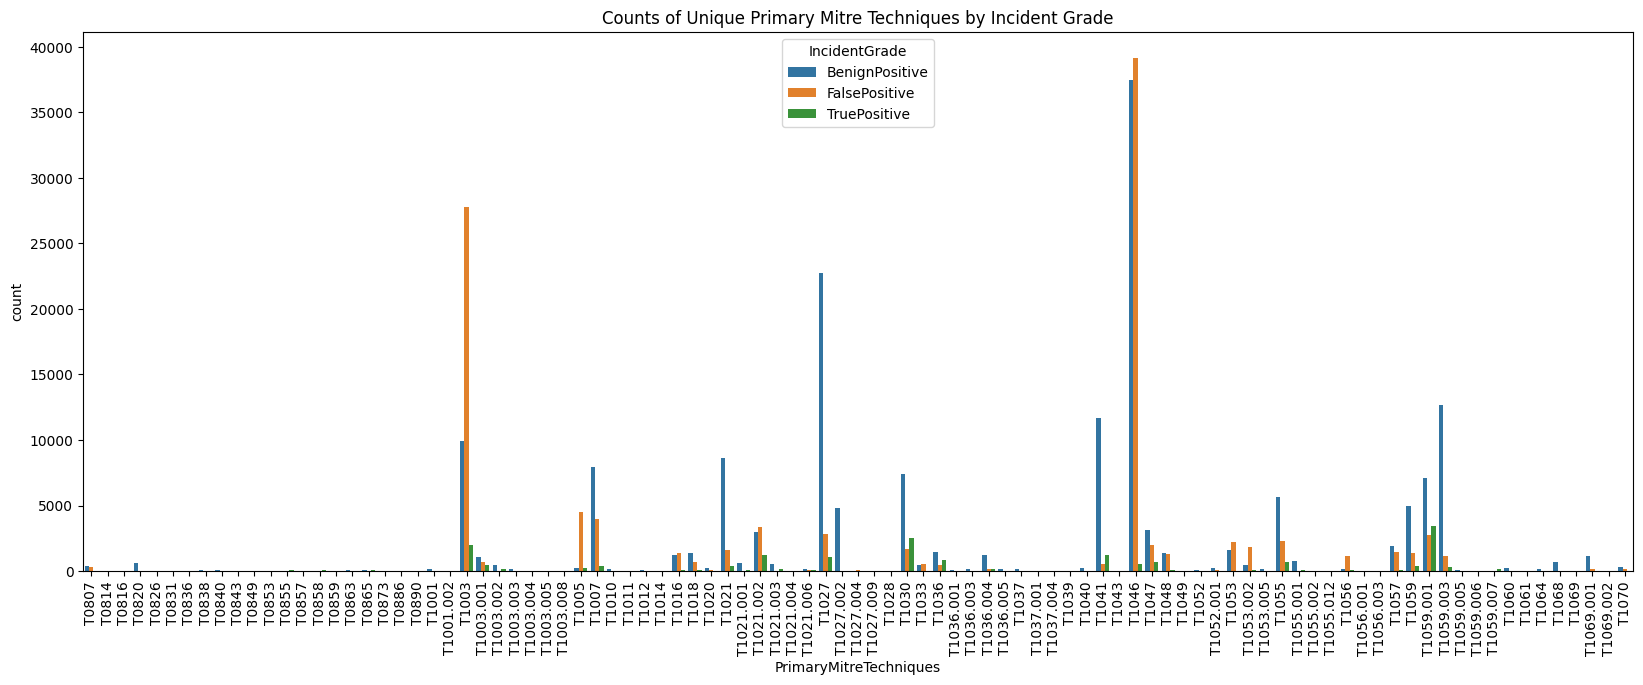

In [40]:
plt.figure(figsize=(20,7))
sns.barplot(data=grouped_data.head(200),x="PrimaryMitreTechniques",y="count",hue="IncidentGrade")
plt.xticks(rotation=90)
plt.title("Counts of Unique Primary Mitre Techniques by Incident Grade")
plt.show()

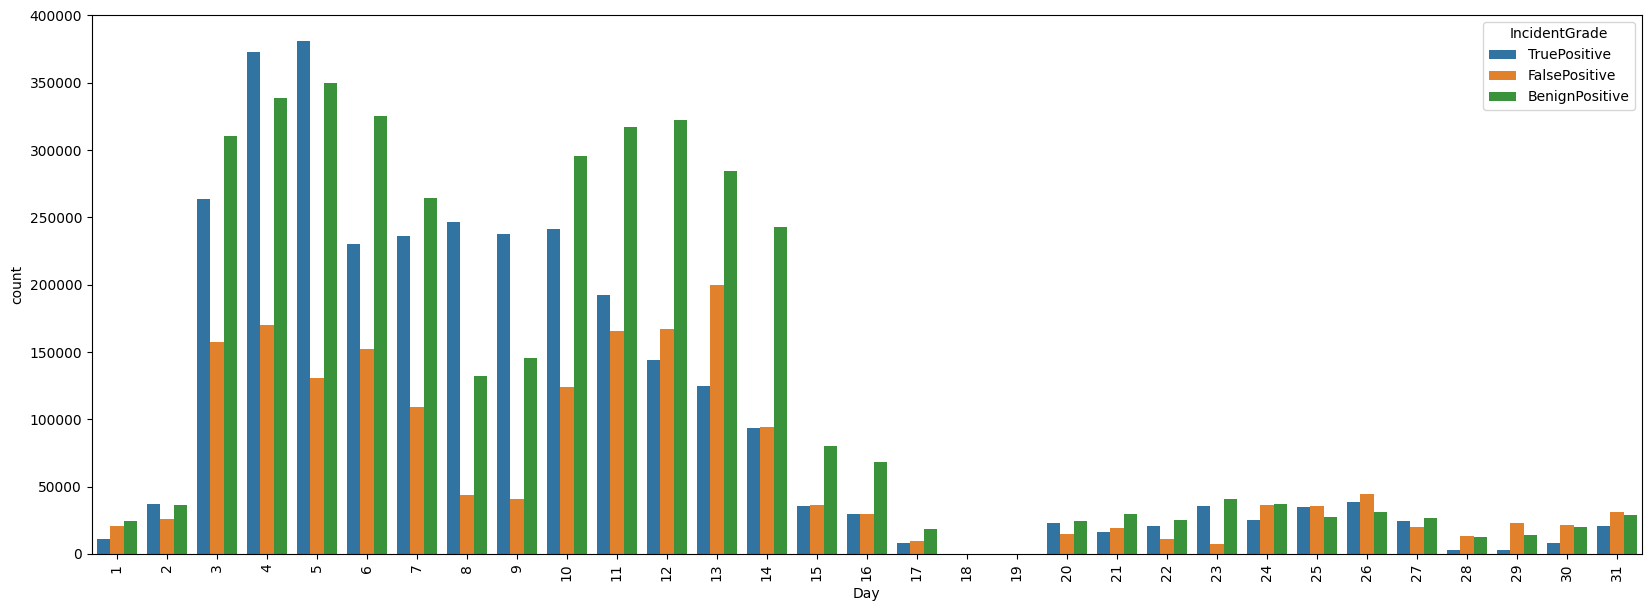

In [41]:
plt.figure(figsize=(20,7))
sns.countplot(data=data,x="Day",hue="IncidentGrade")
plt.xticks(rotation=90)
plt.show()

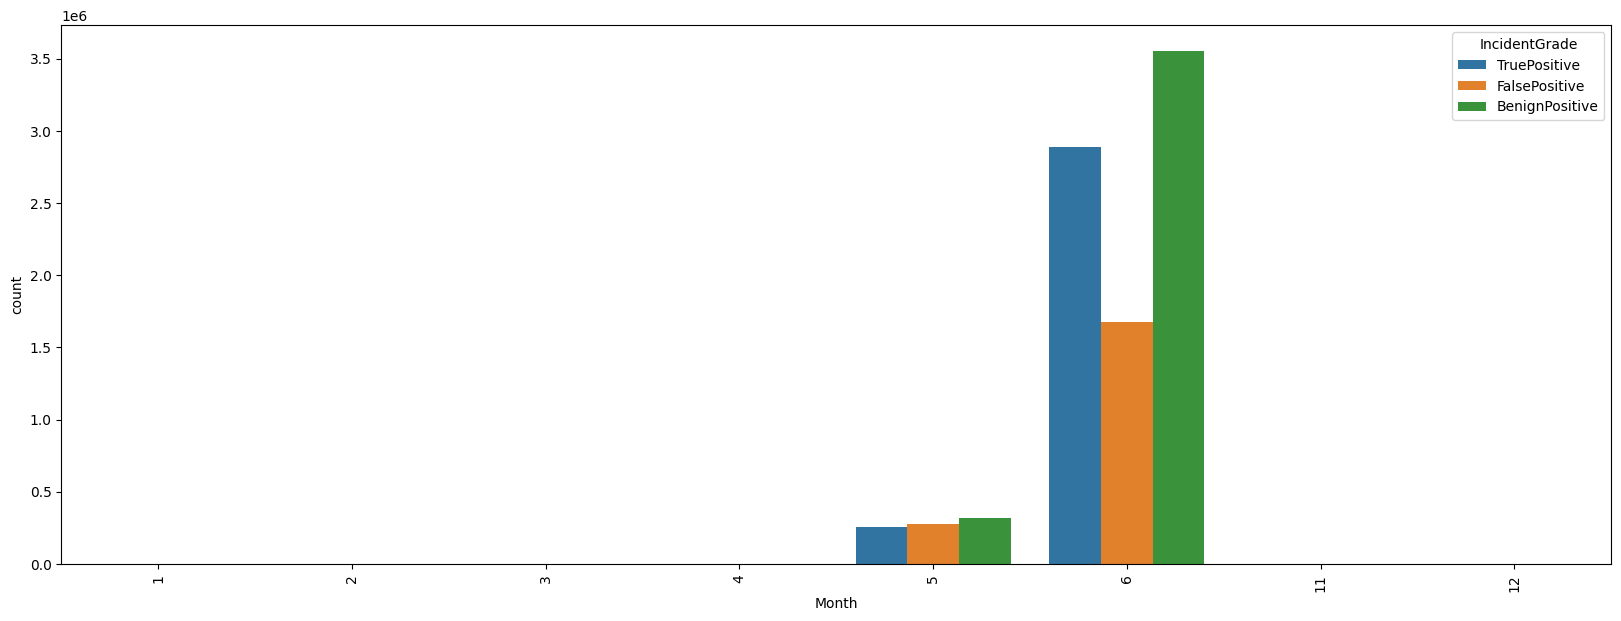

In [42]:
plt.figure(figsize=(20,7))
sns.countplot(data=data,x="Month",hue="IncidentGrade")
plt.xticks(rotation=90)
plt.show()

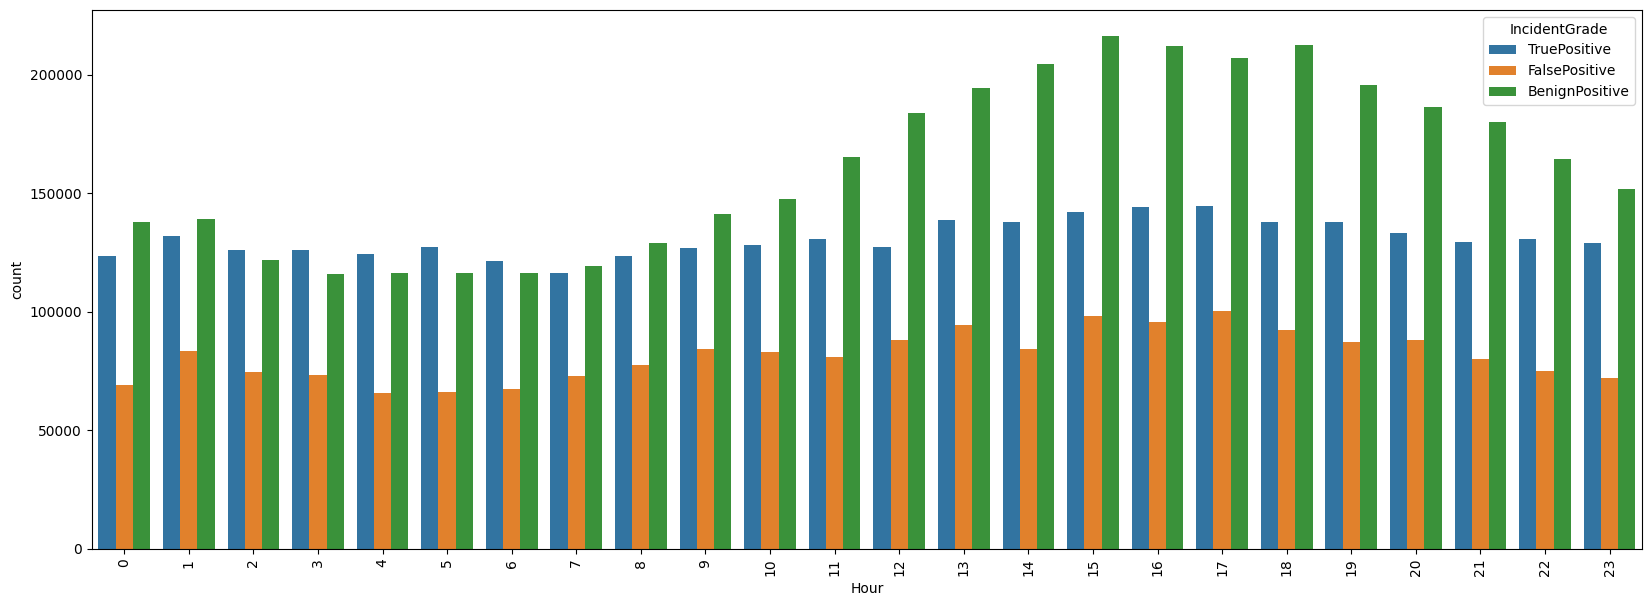

In [43]:
plt.figure(figsize=(20,7))
sns.countplot(data=data,x="Hour",hue="IncidentGrade")
plt.xticks(rotation=90)
plt.show()

In [44]:
data.to_csv('/Users/jainivedhitha/Desktop/data_cleaningtr.csv', index=False)

ENCODING TRAIN DATASET

In [45]:
data_cleaned = pd.read_csv('/Users/jainivedhitha/Desktop/data_cleaningtr.csv')

In [46]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8970539 entries, 0 to 8970538
Data columns (total 41 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Id                      int64 
 1   OrgId                   int64 
 2   IncidentId              int64 
 3   AlertId                 int64 
 4   DetectorId              int64 
 5   AlertTitle              int64 
 6   Category                object
 7   MitreTechniques         object
 8   IncidentGrade           object
 9   EntityType              object
 10  EvidenceRole            object
 11  DeviceId                int64 
 12  Sha256                  int64 
 13  IpAddress               int64 
 14  Url                     int64 
 15  AccountSid              int64 
 16  AccountUpn              int64 
 17  AccountObjectId         int64 
 18  AccountName             int64 
 19  DeviceName              int64 
 20  NetworkMessageId        int64 
 21  RegistryKey             int64 
 22  RegistryValueName 

In [47]:
categorical_columns = data_cleaned.select_dtypes(include=["object"]).columns

In [48]:
encoders = {}

In [49]:
for i in categorical_columns:
    le=LabelEncoder()
    data_cleaned[i]= le.fit_transform(data_cleaned[i])
    encoders[i]=le

In [50]:
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [51]:
numeric_columns = data_cleaned.select_dtypes(include=["int32","int64"]).columns

In [52]:
scaler = StandardScaler()

In [53]:
data_cleaned[numeric_columns] =scaler.fit_transform(data_cleaned[numeric_columns])

In [54]:
with open("scaler.pkl","wb") as s:
    pickle.dump(scaler,s)

In [55]:
data_cleaned.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Year,Hour,Time,PrimaryMitreTechniques
0,-1.331343,-0.450898,-0.572306,-0.639609,-0.245369,-0.264468,0.303672,-0.822488,1.228764,-0.584096,0.930444,0.197291,0.288598,-1.953449,0.255918,0.531136,0.700171,0.527188,0.550296,0.281788,0.328406,0.043667,0.021737,0.024022,0.155711,0.157956,0.016316,0.34484,0.321839,0.028765,0.148242,0.14835,-2.982358,-3.732941,-3.710702,-0.928101,0.320846,0.004467,-0.908096,-0.968549,-0.897890
1,-0.778011,-0.221895,-0.574621,-0.453850,-0.131205,-0.261324,-0.462123,-0.822488,0.093102,1.353254,-1.074756,0.197291,0.288598,0.549623,0.255918,-1.991865,-1.571154,-2.000761,-1.909372,0.281788,0.328406,0.043667,0.021737,0.024022,0.155711,0.157956,0.016316,0.34484,0.321839,0.028765,0.148242,0.14835,0.300031,0.273622,0.273335,0.667594,0.320846,0.004467,-1.351533,-1.421131,-0.897890
2,0.432402,1.654362,-0.104870,0.621624,0.685852,-0.239657,0.303672,-0.083107,0.093102,1.239292,0.930444,0.197291,0.288598,0.549623,-2.264580,0.531136,0.700171,0.527188,0.550296,0.281788,0.328406,0.043667,0.021737,0.024022,0.155711,0.157956,0.016316,0.34484,0.321839,0.028765,0.148242,0.14835,0.300031,0.273622,0.273335,0.508025,0.320846,0.004467,-1.203720,-1.146628,-0.318317
3,0.881984,-0.211486,-0.310173,0.753886,-0.256561,-0.264808,-1.993713,1.051541,-1.042560,1.239292,0.930444,0.197291,0.288598,0.549623,-4.150311,0.531136,0.700171,0.527188,0.550296,0.281788,0.328406,0.043667,0.021737,0.024022,0.155711,0.157956,0.016316,0.34484,0.321839,0.028765,0.148242,0.14835,0.300031,0.273622,0.273335,0.029316,0.320846,0.004467,0.570027,0.593163,1.103277
4,-1.262177,-0.065758,-0.541972,-0.500926,-0.240892,-0.258690,-0.717388,-0.822488,1.228764,1.353254,-1.074756,0.197291,0.288598,0.549623,0.255918,-2.124088,-1.649459,-2.140967,-2.049508,0.281788,0.328406,0.043667,0.021737,0.024022,0.155711,0.157956,0.016316,0.34484,0.321839,0.028765,0.148242,0.14835,0.300031,0.273622,0.273335,0.827164,0.320846,0.004467,-1.647157,-1.700065,-0.897890


In [56]:
threshold = 0.7

In [57]:
corr_matrix = data_cleaned.corr()

In [58]:
columns_to_drop = set()

In [59]:
for i in range(corr_matrix.shape[0]):
    for j in range(i + 1, corr_matrix.shape[1]):
        if corr_matrix.iloc[i, j] > threshold:
            colname = corr_matrix.columns[j]
            columns_to_drop.add(colname)

In [60]:
data_cleaned = data_cleaned.drop(columns=list(columns_to_drop))

In [61]:
data_cleaned.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'MitreTechniques', 'IncidentGrade', 'EntityType',
       'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid',
       'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName',
       'ApplicationId', 'OAuthApplicationId', 'ResourceIdName', 'OSFamily',
       'CountryCode', 'Day', 'Month', 'Year', 'Hour'],
      dtype='object')

TRAIN TEST SPLIT

In [62]:
data_cleaned.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,ApplicationId,OAuthApplicationId,ResourceIdName,OSFamily,CountryCode,Day,Month,Year,Hour
0,-1.331343,-0.450898,-0.572306,-0.639609,-0.245369,-0.264468,0.303672,-0.822488,1.228764,-0.584096,0.930444,0.197291,0.288598,-1.953449,0.255918,0.531136,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,-2.982358,-0.928101,0.320846,0.004467,-0.908096
1,-0.778011,-0.221895,-0.574621,-0.453850,-0.131205,-0.261324,-0.462123,-0.822488,0.093102,1.353254,-1.074756,0.197291,0.288598,0.549623,0.255918,-1.991865,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,0.300031,0.667594,0.320846,0.004467,-1.351533
2,0.432402,1.654362,-0.104870,0.621624,0.685852,-0.239657,0.303672,-0.083107,0.093102,1.239292,0.930444,0.197291,0.288598,0.549623,-2.264580,0.531136,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,0.300031,0.508025,0.320846,0.004467,-1.203720
3,0.881984,-0.211486,-0.310173,0.753886,-0.256561,-0.264808,-1.993713,1.051541,-1.042560,1.239292,0.930444,0.197291,0.288598,0.549623,-4.150311,0.531136,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,0.300031,0.029316,0.320846,0.004467,0.570027
4,-1.262177,-0.065758,-0.541972,-0.500926,-0.240892,-0.258690,-0.717388,-0.822488,1.228764,1.353254,-1.074756,0.197291,0.288598,0.549623,0.255918,-2.124088,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,0.300031,0.827164,0.320846,0.004467,-1.647157


In [63]:
X= data_cleaned.drop("IncidentGrade",axis=1)

In [64]:
y= data_cleaned["IncidentGrade"]

In [65]:

data_cleaned["IncidentGrade"].value_counts()

IncidentGrade
-1.042560    3875534
 1.228764    3140126
 0.093102    1954879
Name: count, dtype: int64

In [66]:
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import pandas as pd


In [67]:
print(y.dtype)
print(y.head())


float64
0    1.228764
1    0.093102
2    0.093102
3   -1.042560
4    1.228764
Name: IncidentGrade, dtype: float64


In [68]:
# Example: Binning continuous values into categories
y= pd.cut(y, bins=3, labels=["Low", "Medium", "High"])  # Adjust bins/labels as needed


In [69]:
smote = SMOTE(random_state=100)
desired_chunk_size = 500000  
n_chunks = max(1, len(X) // desired_chunk_size)

In [70]:
X_new_list = []
y_new_list = []

In [71]:
for i in tqdm(range(n_chunks)):
    start_index = i * desired_chunk_size
    end_index = (i + 1) * desired_chunk_size if i != n_chunks - 1 else len(X)
    
    # Extract current chunk
    X_chunk = X.iloc[start_index:end_index]
    y_chunk = y.iloc[start_index:end_index]

    # Apply SMOTE to the chunk
    try:
        # Ensure target is suitable for SMOTE (check for classification)
        if y_chunk.nunique() > 1 and y_chunk.dtype in ['int', 'object', 'category']: 
            X_new_chunk, y_new_chunk = smote.fit_resample(X_chunk, y_chunk)
            X_new_list.append(X_new_chunk)
            y_new_list.append(y_new_chunk)
        else:
            print(f"Skipping chunk {i} due to unsuitable target variable for SMOTE.")
    except ValueError as e:
        print(f"Skipping chunk {i} due to error: {e}")

100%|██████████| 17/17 [1:04:26<00:00, 227.44s/it]


In [72]:
X_new = pd.concat(X_new_list, ignore_index=True)
y_new = pd.concat(y_new_list, ignore_index=True)

In [73]:

print(f"Final resampled dataset size: {X_new.shape}, {y_new.shape}")

Final resampled dataset size: (11626602, 28), (11626602,)


In [74]:
print("Class distribution after SMOTE:")
print(y_new.value_counts())

Class distribution after SMOTE:
IncidentGrade
Low       3875534
Medium    3875534
High      3875534
Name: count, dtype: int64


In [75]:
X.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,ApplicationId,OAuthApplicationId,ResourceIdName,OSFamily,CountryCode,Day,Month,Year,Hour
0,-1.331343,-0.450898,-0.572306,-0.639609,-0.245369,-0.264468,0.303672,-0.822488,-0.584096,0.930444,0.197291,0.288598,-1.953449,0.255918,0.531136,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,-2.982358,-0.928101,0.320846,0.004467,-0.908096
1,-0.778011,-0.221895,-0.574621,-0.453850,-0.131205,-0.261324,-0.462123,-0.822488,1.353254,-1.074756,0.197291,0.288598,0.549623,0.255918,-1.991865,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,0.300031,0.667594,0.320846,0.004467,-1.351533
2,0.432402,1.654362,-0.104870,0.621624,0.685852,-0.239657,0.303672,-0.083107,1.239292,0.930444,0.197291,0.288598,0.549623,-2.264580,0.531136,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,0.300031,0.508025,0.320846,0.004467,-1.203720
3,0.881984,-0.211486,-0.310173,0.753886,-0.256561,-0.264808,-1.993713,1.051541,1.239292,0.930444,0.197291,0.288598,0.549623,-4.150311,0.531136,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,0.300031,0.029316,0.320846,0.004467,0.570027
4,-1.262177,-0.065758,-0.541972,-0.500926,-0.240892,-0.258690,-0.717388,-0.822488,1.353254,-1.074756,0.197291,0.288598,0.549623,0.255918,-2.124088,0.281788,0.328406,0.043667,0.021737,0.155711,0.016316,0.028765,0.148242,0.300031,0.827164,0.320846,0.004467,-1.647157


In [76]:
df = pd.concat([X_new, y_new], axis=1)

In [77]:
df.to_csv("/Users/jainivedhitha/Desktop/data_smote.csv", index=False)

In [78]:
df = pd.read_csv("/Users/jainivedhitha/Desktop/data_smote.csv")

In [79]:
X=df.drop("IncidentGrade",axis=1)

In [80]:
y=df["IncidentGrade"]

FEATURE SELECTION USING RANDOM FOREST

In [81]:
rf = RandomForestClassifier(n_estimators=200, random_state=100, n_jobs=-1,criterion="entropy",max_depth=10)

In [82]:
#rf.fit(X,y)

In [83]:
#fs_score=pd.DataFrame({
#    "columns":X.columns,
#    "score": rf.feature_importances_
#}).sort_values("score",ascending=False)

In [84]:
#fs_score

In [85]:
X_new = X.drop(columns = ['DeviceId','ApplicationId','RegistryKey','OSFamily','ResourceIdName','RegistryValueName','OAuthApplicationId','Year'], axis = 1)

In [86]:
#list(fs_score.head(20)["columns"].values)

In [87]:
#selected_features =list(fs_score.sort_values("score",ascending=False).head(20)["columns"].values)

In [88]:
#X_new=X[selected_features]

In [89]:
X_new.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Sha256,IpAddress,Url,AccountSid,DeviceName,NetworkMessageId,CountryCode,Day,Month,Hour
0,-1.331343,-0.450898,-0.572306,-0.639609,-0.245369,-0.264468,0.303672,-0.822488,-0.584096,0.930444,0.288598,-1.953449,0.255918,0.531136,0.281788,0.328406,-2.982358,-0.928101,0.320846,-0.908096
1,-0.778011,-0.221895,-0.574621,-0.453850,-0.131205,-0.261324,-0.462123,-0.822488,1.353254,-1.074756,0.288598,0.549623,0.255918,-1.991865,0.281788,0.328406,0.300031,0.667594,0.320846,-1.351533
2,0.432402,1.654362,-0.104870,0.621624,0.685852,-0.239657,0.303672,-0.083107,1.239292,0.930444,0.288598,0.549623,-2.264580,0.531136,0.281788,0.328406,0.300031,0.508025,0.320846,-1.203720
3,0.881984,-0.211486,-0.310173,0.753886,-0.256561,-0.264808,-1.993713,1.051541,1.239292,0.930444,0.288598,0.549623,-4.150311,0.531136,0.281788,0.328406,0.300031,0.029316,0.320846,0.570027
4,-1.262177,-0.065758,-0.541972,-0.500926,-0.240892,-0.258690,-0.717388,-0.822488,1.353254,-1.074756,0.288598,0.549623,0.255918,-2.124088,0.281788,0.328406,0.300031,0.827164,0.320846,-1.647157


In [90]:
X_new.drop("MitreTechniques",axis=1,inplace=True)

In [91]:
X_train,X_valid,y_train,y_valid=train_test_split(X_new,y,test_size=0.2,random_state=59)

In [92]:
data_x = X_new.corr()

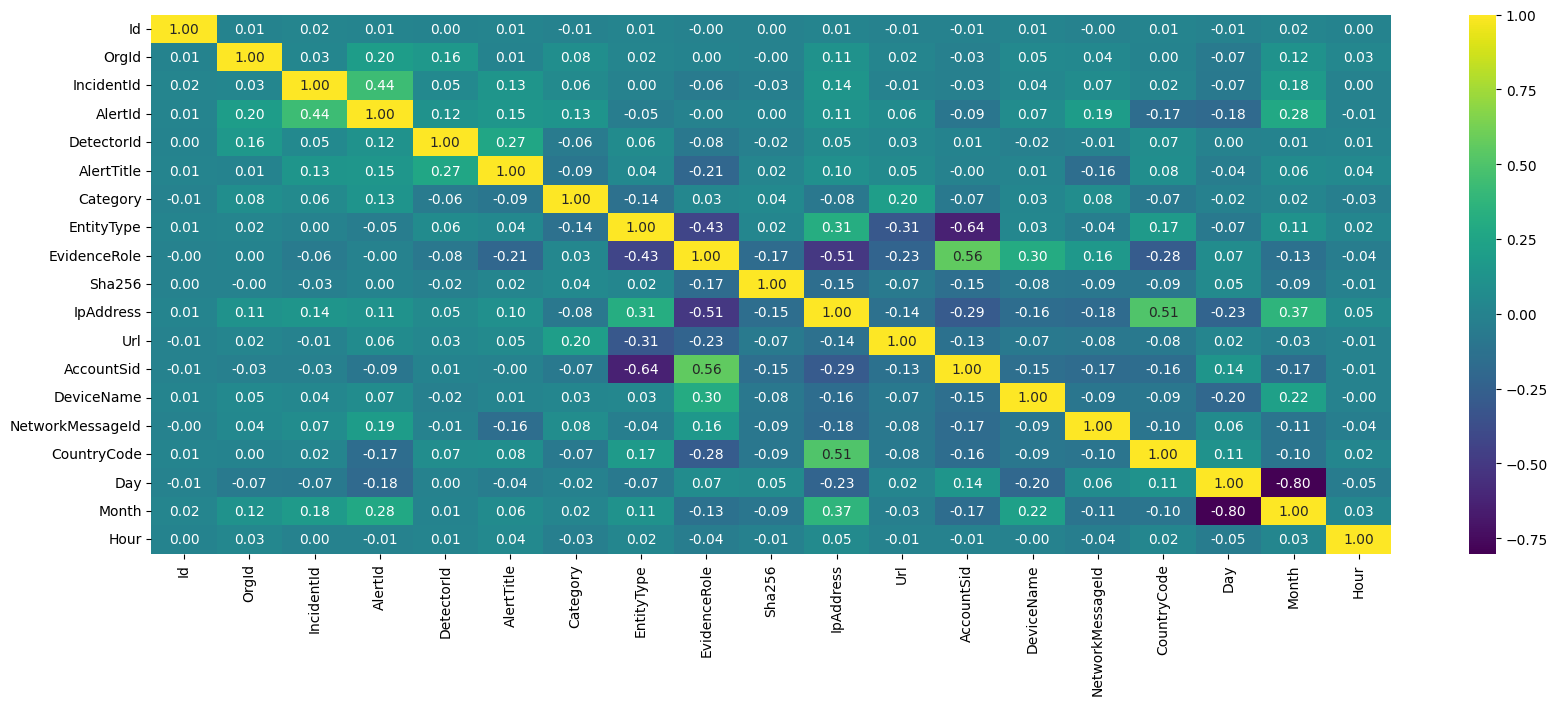

In [93]:
plt.figure(figsize=(20,7))
sns.heatmap(data=data_x,annot=True,fmt=".2f",cmap="viridis")
plt.show()

In [94]:
X_new.drop(["AccountSid"],axis=1,inplace=True)

In [95]:
X_new.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,EntityType,EvidenceRole,Sha256,IpAddress,Url,DeviceName,NetworkMessageId,CountryCode,Day,Month,Hour
0,-1.331343,-0.450898,-0.572306,-0.639609,-0.245369,-0.264468,0.303672,-0.584096,0.930444,0.288598,-1.953449,0.255918,0.281788,0.328406,-2.982358,-0.928101,0.320846,-0.908096
1,-0.778011,-0.221895,-0.574621,-0.453850,-0.131205,-0.261324,-0.462123,1.353254,-1.074756,0.288598,0.549623,0.255918,0.281788,0.328406,0.300031,0.667594,0.320846,-1.351533
2,0.432402,1.654362,-0.104870,0.621624,0.685852,-0.239657,0.303672,1.239292,0.930444,0.288598,0.549623,-2.264580,0.281788,0.328406,0.300031,0.508025,0.320846,-1.203720
3,0.881984,-0.211486,-0.310173,0.753886,-0.256561,-0.264808,-1.993713,1.239292,0.930444,0.288598,0.549623,-4.150311,0.281788,0.328406,0.300031,0.029316,0.320846,0.570027
4,-1.262177,-0.065758,-0.541972,-0.500926,-0.240892,-0.258690,-0.717388,1.353254,-1.074756,0.288598,0.549623,0.255918,0.281788,0.328406,0.300031,0.827164,0.320846,-1.647157


In [96]:
X_new.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,EntityType,EvidenceRole,Sha256,IpAddress,Url,DeviceName,NetworkMessageId,CountryCode,Day,Month,Hour
0,-1.331343,-0.450898,-0.572306,-0.639609,-0.245369,-0.264468,0.303672,-0.584096,0.930444,0.288598,-1.953449,0.255918,0.281788,0.328406,-2.982358,-0.928101,0.320846,-0.908096
1,-0.778011,-0.221895,-0.574621,-0.453850,-0.131205,-0.261324,-0.462123,1.353254,-1.074756,0.288598,0.549623,0.255918,0.281788,0.328406,0.300031,0.667594,0.320846,-1.351533
2,0.432402,1.654362,-0.104870,0.621624,0.685852,-0.239657,0.303672,1.239292,0.930444,0.288598,0.549623,-2.264580,0.281788,0.328406,0.300031,0.508025,0.320846,-1.203720
3,0.881984,-0.211486,-0.310173,0.753886,-0.256561,-0.264808,-1.993713,1.239292,0.930444,0.288598,0.549623,-4.150311,0.281788,0.328406,0.300031,0.029316,0.320846,0.570027
4,-1.262177,-0.065758,-0.541972,-0.500926,-0.240892,-0.258690,-0.717388,1.353254,-1.074756,0.288598,0.549623,0.255918,0.281788,0.328406,0.300031,0.827164,0.320846,-1.647157


In [97]:
X_new.shape

(11626602, 18)

In [98]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y,test_size=0.2,random_state=100)

In [99]:
X_train.shape

(9301281, 18)

In [100]:
X_test.shape

(2325321, 18)

    DECISION TREE

In [101]:
dt_model= DecisionTreeClassifier(max_depth=8,random_state=100,min_samples_split=10,min_samples_leaf=5,max_features="sqrt")

In [102]:
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, random_state=100)

In [103]:
def metrics(actual, predicted):
    acc = accuracy_score(actual, predicted) * 100
    prec = precision_score(actual, predicted, average="macro") * 100
    recall = recall_score(actual, predicted, average="macro") * 100
    macro_f1 = f1_score(actual, predicted, average="macro") * 100 
    
    return pd.DataFrame({
        "Metrics": ["Accuracy", "Precision", "Recall", "Macro F1"],
        "Values": [acc, prec, recall, macro_f1]
    }).set_index("Metrics")

In [104]:
dttr_pred =dt_model.predict(X_train)
dtts_pred =dt_model.predict(X_test)

In [105]:
dttrain_metrics=metrics(y_train,dttr_pred)

In [106]:
dttest_metrics=metrics(y_test,dtts_pred)

In [107]:
pd.DataFrame({
    "Training":dttrain_metrics["Values"],
    "Testing":dttest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,62.516120,62.459807
1,Precision,66.686728,66.631603
2,Recall,62.517025,62.456193
3,Macro F1,63.179571,63.126405


In [108]:
print(classification_report(y_test,dtts_pred))

              precision    recall  f1-score   support

        High       0.88      0.58      0.70    774485
         Low       0.51      0.67      0.58    776273
      Medium       0.62      0.63      0.62    774563

    accuracy                           0.62   2325321
   macro avg       0.67      0.62      0.63   2325321
weighted avg       0.67      0.62      0.63   2325321



    RANDOM FOREST

In [109]:
rfc =RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=100)

In [ ]:
rfc.fit(X_train,y_train)

In [ ]:
rftr_pred =rfc.predict(X_train)
rfts_pred =rfc.predict(X_test)

In [ ]:
rftrain_metrics=metrics(y_train,rftr_pred)
rftest_metrics=metrics(y_test,rfts_pred)

In [ ]:
rftrain_metrics=metrics(y_train,rftr_pred)
rftest_metrics=metrics(y_test,rfts_pred)

In [ ]:
pd.DataFrame({
    "Training":rftrain_metrics["Values"],
    "Testing":rftest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,80.996790,80.934804
1,Precision,84.509287,84.486669
2,Recall,80.999184,80.925167
3,Macro F1,81.316631,81.256572


In [ ]:
print(classification_report(y_test,rfts_pred))

              precision    recall  f1-score   support

        High       0.98      0.75      0.85    774485
         Low       0.67      0.94      0.78    776273
      Medium       0.89      0.74      0.81    774563

    accuracy                           0.81   2325321
   macro avg       0.84      0.81      0.81   2325321
weighted avg       0.84      0.81      0.81   2325321



    XGBOOST ALGORITHM

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xgboost

In [ ]:
from sklearn.preprocessing import LabelEncoder


In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  
y_test_encoded = le.fit_transform(y_test)
# Convert labels to numbers

In [ ]:
xgbmodel = xgboost.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)

In [ ]:
xgbmodel.fit(X_train, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
xgbtr_pred =xgbmodel.predict(X_train)
xgbts_pred =xgbmodel.predict(X_test)

In [ ]:
xgbtrain_metrics = metrics(y_train_encoded,xgbtr_pred)
xgbtest_metrics =metrics(y_test_encoded,xgbts_pred)

In [ ]:
pd.DataFrame({
    "Training":xgbtrain_metrics["Values"],
    "Testing":xgbtest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,92.837245,92.766418
1,Precision,92.927241,92.860287
2,Recall,92.837586,92.765041
3,Macro F1,92.845005,92.774743


In [ ]:
print(classification_report(y_test_encoded,xgbts_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93    774485
           1       0.90      0.95      0.92    776273
           2       0.92      0.93      0.93    774563

    accuracy                           0.93   2325321
   macro avg       0.93      0.93      0.93   2325321
weighted avg       0.93      0.93      0.93   2325321



In [ ]:
score = cross_val_score(xgbmodel, X_train, y_train_encoded, cv=3, scoring="accuracy")
print("Cross-validation accuracy: ", score.mean())

Cross-validation accuracy:  0.9304344208071985


In [ ]:
import joblib

In [ ]:
best_model = "/Users/jainivedhitha/Desktop/XGB.joblib"


In [ ]:
with open(best_model, 'wb') as file:
    joblib.dump(xgbmodel, file)

    TEST DATASET

In [ ]:

data_test=pd.read_csv("/Users/jainivedhitha/Downloads/test.csv")

/var/folders/y7/t5zdz9x52q51vhsy889zdj880000gn/T/ipykernel_22063/332696017.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_test=pd.read_csv("/Users/jainivedhitha/Downloads/test.csv")


In [ ]:
data_test.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [ ]:
data_test.isnull().mean()*100

Id                     0.000000
OrgId                  0.000000
IncidentId             0.000000
AlertId                0.000000
Timestamp              0.000000
DetectorId             0.000000
AlertTitle             0.000000
Category               0.000000
MitreTechniques       55.619779
IncidentGrade          0.000000
ActionGrouped         99.953881
ActionGranular        99.953881
EntityType             0.000000
EvidenceRole           0.000000
DeviceId               0.000000
Sha256                 0.000000
IpAddress              0.000000
Url                    0.000000
AccountSid             0.000000
AccountUpn             0.000000
AccountObjectId        0.000000
AccountName            0.000000
DeviceName             0.000000
NetworkMessageId       0.000000
EmailClusterId        98.994526
RegistryKey            0.000000
RegistryValueName      0.000000
RegistryValueData      0.000000
ApplicationId          0.000000
ApplicationName        0.000000
OAuthApplicationId     0.000000
ThreatFa

In [ ]:
threshold = len(data_test)*0.4
data_test = data_test.dropna(thresh=threshold,axis=1)

In [ ]:
data_test.drop_duplicates()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,881,289573,117668,3586,5,66,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,881,289573,117668,3586,0,0,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,881,14,22,3586,5,66,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,881,289573,117668,3586,5,66,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,881,289573,117668,3586,5,66,242,1445,10630,Public
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,171798692464,42,391,638112,2024-06-03T20:24:41.000Z,135,7322,Malware,NaN,BenignPositive,...,881,289573,117668,3586,0,0,242,1445,10630,Public
4147987,541165881145,262,3017,227156,2024-06-04T03:53:15.000Z,139,120,InitialAccess,T1566.002,BenignPositive,...,881,289573,117668,3586,5,66,242,1445,10630,Public
4147988,438086666953,1323,31001,304819,2024-06-04T19:32:19.000Z,219,196,InitialAccess,NaN,BenignPositive,...,881,289573,117668,3586,5,66,242,1445,10630,Private
4147989,1297080124487,47,3653,7243,2024-06-15T00:50:22.000Z,57,29,CommandAndControl,T1046;T1071;T1210,FalsePositive,...,881,289573,117668,3586,5,66,242,1445,10630,Public


In [ ]:
data_test["IncidentGrade"].fillna(data_test["IncidentGrade"].mode()[0],inplace=True)

In [ ]:
data_test["Timestamp"]

0          2024-06-04T22:56:27.000Z
1          2024-06-03T12:58:26.000Z
2          2024-06-08T03:20:49.000Z
3          2024-06-12T12:07:31.000Z
4          2024-06-06T17:42:05.000Z
                     ...           
4147987    2024-06-04T03:53:15.000Z
4147988    2024-06-04T19:32:19.000Z
4147989    2024-06-15T00:50:22.000Z
4147990    2024-06-11T16:18:12.000Z
4147991    2024-06-04T18:11:09.000Z
Name: Timestamp, Length: 4147992, dtype: object

In [ ]:
data_test["Timestamp"] = data_test["Timestamp"].str.replace(r"\.\d{3}Z$","Z",regex=True)

In [ ]:
data_test["Timestamp"] = pd.to_datetime(data_test["Timestamp"])

In [ ]:
data_test["Day"] = data_test["Timestamp"].dt.day
data_test["Month"] = data_test["Timestamp"].dt.month
data_test["Year"] = data_test["Timestamp"].dt.year
data_test["Hour"] =data_test["Timestamp"].dt.hour
data_test["Time"] =data_test["Timestamp"].dt.time
data_test.drop("Timestamp",axis=1,inplace=True)

In [ ]:
data_test["MitreTechniques"].value_counts()

MitreTechniques
T1078;T1078.004                                          615921
T1566.002                                                359720
T1566                                                    275358
T1133                                                    107607
T1566.001                                                 60023
                                                          ...  
T0814;T0816                                                   1
T1087;T1580;T1619;T1482;T1615;T1201;T1069;T1082;T1033         1
T0814                                                         1
T1125                                                         1
T1007;T1033;T1053                                             1
Name: count, Length: 985, dtype: int64

In [ ]:
missing_datas = data_test.groupby(data_test["MitreTechniques"].isnull())['IncidentGrade'].value_counts()

In [ ]:
technique_count=data_test.groupby(["IncidentGrade", "MitreTechniques"]).size().reset_index(name="count")

In [ ]:
sorted_technique= technique_count.sort_values(["IncidentGrade","count"],ascending=[True, False])

In [ ]:
most_commons=sorted_technique.loc[sorted_technique.groupby("IncidentGrade")["count"].idxmax()]

In [ ]:
fill_mapping = {
    "BenignPositive":"T1566.002",
    "FalsePositive":"T1078;T1078.004",
    "TruePositive":"T1078;T1078.004"
}
# Fill missing MitreTechniques based on IncidentGrade
for grade,technique in fill_mapping.items():
    data_test.loc[data_test["IncidentGrade"] == grade,"MitreTechniques"] = data_test["MitreTechniques"].fillna(technique)


In [ ]:
data_test.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
DetectorId            0
AlertTitle            0
Category              0
MitreTechniques       0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Usage                 0
Day                   0
Month                 0
Year                  0
Hour                  0
Time                  0
dtype: int64

    ENCODING

In [ ]:
data_test['MitreTechniques'] = data_test['MitreTechniques'].astype('str')


In [ ]:
data_test["PrimaryMitreTechniques"] = data_test["MitreTechniques"].map(lambda x: x.split(";")[0])

In [ ]:
data_test.isnull().sum()

Id                        0
OrgId                     0
IncidentId                0
AlertId                   0
DetectorId                0
AlertTitle                0
Category                  0
MitreTechniques           0
IncidentGrade             0
EntityType                0
EvidenceRole              0
DeviceId                  0
Sha256                    0
IpAddress                 0
Url                       0
AccountSid                0
AccountUpn                0
AccountObjectId           0
AccountName               0
DeviceName                0
NetworkMessageId          0
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
FileName                  0
FolderPath                0
ResourceIdName            0
OSFamily                  0
OSVersion                 0
CountryCode               0
State                     0
City                      0
Usage               

In [ ]:
#REMOVING COLUMNS WHICH HAS 50% MORE MISSING DATA

threshold = len(data_test)*0.4
data_test = data_test.dropna(thresh=threshold,axis=1)

In [ ]:
categorical_columns = data_test.select_dtypes(include=["object"]).columns

In [ ]:
encoders = {}

for i in categorical_columns:
    le=LabelEncoder()
    data_test[i]= le.fit_transform(data_test[i])
    encoders[i]=le
    data_test[i] = data_test[i].astype(int)


In [ ]:
# Save the encoders dictionary
with open("encoder_test.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [ ]:
for column in categorical_columns:
    if column in data_cleaned.columns and column in data_test.columns:
        print(f"Training unique values for {column}: {data_cleaned[column].unique()}")
        print(f"Test unique values for {column}: {data_test[column].unique()}")

Training unique values for Category: ['InitialAccess' 'Exfiltration' 'CommandAndControl' 'Execution'
 'SuspiciousActivity' 'Impact' 'Collection' 'CredentialAccess'
 'Persistence' 'Discovery' 'Malware' 'DefenseEvasion' 'Exploit'
 'PrivilegeEscalation' 'LateralMovement' 'Ransomware' 'UnwantedSoftware'
 'CredentialStealing' 'WebExploit' 'Weaponization']
Test unique values for Category: [11  1 10  5 16  9  2  7 17  4 12  6 13  3  0 15  8 14 18]
Training unique values for MitreTechniques: ['T1078;T1078.004' 'T1189' 'T1566.002' ...
 'T1055;T1055.002;T1055.004;T1055.012;T1071;T1106' 'T1566;T0865;T1650'
 'T1078;T1078.001']
Test unique values for MitreTechniques: [311 920 303 577 610 666 917 170 937 392 474 556 692  78 895 918 661 656
 560 393 578 567 489 660 365 325 521 659 339 607 564 652 497 111 473 128
 166  68 516 641 814 406 525 233 342 697 719 331 819 929 721 757 787 390
 461 967 162 806 600 447 801 531 747 290 901 795 436 944 838  57 824 550
 740 598 800 391 782 167 866  39  44 151   9 

    STANDARD SCALER

In [ ]:
with open("scaler.pkl", "rb") as f:
    scaler_encoders = pickle.load(f)

In [ ]:
data_test = data_test.drop(columns=['Usage'],axis = 1)

In [ ]:
numeric_columns = data_test.select_dtypes(include=["int64","int32"]).columns

data_test[numeric_columns] = scaler_encoders.transform(data_test[numeric_columns])

In [ ]:
data_test = data_test.drop(columns=['PrimaryMitreTechniques'])

In [ ]:
df.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'MitreTechniques', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'DeviceName',
       'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'ApplicationId',
       'OAuthApplicationId', 'ResourceIdName', 'OSFamily', 'CountryCode',
       'Day', 'Month', 'Year', 'Hour', 'IncidentGrade'],
      dtype='object')

In [ ]:
data_test = data_test.drop(columns = ['ApplicationId','ResourceIdName','RegistryValueName', 'RegistryKey', 'OSFamily', 'DeviceId', 'MitreTechniques', 
                                      'Year','AccountSid','OAuthApplicationId'])

In [ ]:
data_test = data_test.drop(columns=['OSVersion', 'FileName', 'RegistryValueData', 'FolderPath', 'AccountObjectId', 'AccountUpn', 
                                      'City', 'AccountName', 'Time', 'State', 'ApplicationName'],axis = 1)

    TRAIN TEST SPLIT

In [ ]:
X1=data_test.drop(columns = ['IncidentGrade'],axis = 1)

In [ ]:
y1= data_test["IncidentGrade"]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X1,y1,test_size=0.2,random_state=100)

In [ ]:
X_train.shape

(3318393, 18)

In [ ]:
X_test.shape

(829599, 18)

In [ ]:
best_model = joblib.load("/Users/jainivedhitha/Desktop/XGB.joblib")

In [ ]:
xgbtest_pred = best_model.predict(X_test)


In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  
y_test_encoded = le.fit_transform(y_test)

In [ ]:
xgbtest_pred = xgbtest_pred.astype(int)

In [ ]:
metrics(y_test_encoded,xgbtest_pred).reset_index()

,Metrics,Values
0,Accuracy,92.766418
1,Precision,92.860287
2,Recall,92.765041
3,Macro F1,92.774743


In [ ]:

print(classification_report(y_test_encoded,xgbtest_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93    774485
           1       0.90      0.95      0.92    776273
           2       0.92      0.93      0.93    774563

    accuracy                           0.93   2325321
   macro avg       0.93      0.93      0.93   2325321
weighted avg       0.93      0.93      0.93   2325321

